# 量子テレポーテーション実験
このNotebookでは、Qiskitを用いて量子テレポーテーション回路を実装し、
理想シミュレーション・ノイズ付きシミュレーション・実機実行の比較を行う。


## 1. はじめに
量子テレポーテーションは、エンタングルメントと古典通信を組み合わせることで、未知の量子状態を離れた場所に転送するプロトコルである。この手法は量子通信や量子ネットワークの基盤となる重要な技術であり、実機での実装やノイズの影響の解析は今後の量子情報科学において欠かせない。本notebookでは、Qiskitを用いて量子テレポーテーション回路を実装し、理想シミュレーション・ノイズ付きシミュレーション・IBM実機での実行結果を比較し、その特性と限界について考察する。

## 2.原理

量子テレポーテーションとは、ある粒子の量子状態を、その粒子を直接送らずに遠隔地へと移す方法である。重要なのは「粒子そのものが移動する」のではなく、「粒子に宿っている量子状態がコピー不可能な形で転送される」という点である。

### 2.1 EPR相関と量子もつれ

基礎となるのが **EPRパラドックス**（Einstein, Podolsky, Rosen, 1935）である。
量子力学によれば、粒子の状態は観測されるまで確定せず、重ね合わせの状態にある。例えばスピンを持つ電子であれば、

$$
|\psi\rangle = \alpha |\uparrow\rangle + \beta |\downarrow\rangle, \quad |\alpha|^2 + |\beta|^2 = 1
$$

のように「上向き」と「下向き」が同時に存在する状態である。

２つの粒子を同時に生成すると、両者は「絡み合った状態（entangled state）」を作ることができる。代表的なのは ベル状態と呼ばれるもので、例えば次のように表される

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \Big( |\uparrow\rangle_A |\uparrow\rangle_B + |\downarrow\rangle_A |\downarrow\rangle_B \Big)
$$

この状態では、AとBはどんなに遠く離れても「一方を測定すればもう一方の状態も即座に決まる」ような相関を持つ。これがEPR相関である。

ただし、この仕組みだけでは「情報を送る」ことはできない。測定結果はランダムであり、意図的に制御できないからである。


### 2.2 テレポーテーションの仕組み

1993年、Bennett らが提案したのが「量子テレポーテーション」である。
ここでは「送信したい状態」と「共有されたEPRペア」を組み合わせることで、量子情報を遠隔地へ移す。

**送信したい状態（未知の量子状態）**

   $$
   |\psi\rangle_S = \alpha |0\rangle + \beta |1\rangle
   $$

**共有するEPRペア（アリスとボブ）**

   $$
   |\Phi^+\rangle_{AB} = \frac{1}{\sqrt{2}} \Big( |0\rangle_X |0\rangle_Y + |1\rangle_X |1\rangle_Y \Big)
   $$

**全体の初期状態**は３粒子系で

   $$
   |\Psi\rangle = |\psi\rangle_S \otimes |\Phi^+\rangle_{XY}
   $$

アリスは「SとAをまとめてベル基底で測定」する。この測定結果は４通りあり、それぞれ等確率（25%ずつ）で現れる。測定によって、ボブの粒子Bは次のいずれかの状態に移る

①そのまま $|\psi\rangle$, ②$\sigma_x |\psi\rangle$, ③$\sigma_z |\psi\rangle$, ④$\sigma_x \sigma_z |\psi\rangle$

（ここで $\sigma_x, \sigma_z$ はパウリ行列）

アリスは自分の測定結果（２ビットの古典情報）をボブに送る。ボブはそれを受け取り、対応する操作（単位行列 or $\sigma_x$ or $\sigma_z$ or $\sigma_x\sigma_z$）を施すことで、元の状態 $|\psi\rangle$ を完全に再現できる。

no-cloning theorem（量子状態の複製禁止定理） に反しない。元のSは測定によって消滅し、ボブの側にだけ $|\psi\rangle$ が現れる。

![image1](https://raw.githubusercontent.com/kyoka1013/my-qiskit-project/main/image/image1.jpg)
![image2](https://raw.githubusercontent.com/kyoka1013/my-qiskit-project/main/image/image2.jpg)





## 3. 実装方法

本実験では、量子テレポーテーションをPythonとQiskitを用いてシミュレーションおよび実機実験を行った。

### 3.1 回路構成

テレポーテーションの回路は、3量子ビットと2古典ビットで構成した。

 **q0**: Aliceが送信する未知状態 $|\psi\rangle$
 **q1**: Alice側のエンタングル粒子
 **q2**: Bob側の粒子

シミュレーションの場合、回路の手順は以下の通りである。

1. **未知状態の準備**
   $|\psi\rangle = \cos(\theta/2)|0\rangle + e^{i\phi}\sin(\theta/2)|1\rangle$ を q0 に設定

   ```python
   qc.ry(theta, q0)
   qc.rz(phi, q0)
   ```
2. **EPRペアの生成**

   ```python
   qc.h(q1)
   qc.cx(q1, q2)
   ```
3. **Aliceによるベル測定**

   ```python
   qc.cx(q0, q1)
   qc.h(q0)
   qc.measure(q0, cr0)
   qc.measure(q1, cr1)
   ```
4. **Bobの補正操作**
   Aliceの測定結果に応じて q2 に条件付き操作 (`x` や `z`) を施す

回路図は Qiskit の `qc.draw("mpl")` で出力した


### 3.2 実験方法

 **理想シミュレーション**: `AerSimulator` を用い、ノイズのない理想状態での忠実度を確認

 **ノイズ付きシミュレーション**: `NoiseModel` を用いて一量子ビット・二量子ビットのデポラリゼーション誤差を反映
 
 **実機実行**: IBM Quantum の `ibm_torino` で実施可能（コード内テンプレートを使用）

### 3.3 忠実度による評価

シミュレーションは理論的に扱うことが出来るため、テレポーテーションの成功度は、密度行列の導入をして送信前の未知状態 $|\psi\rangle$ と Bob が受け取った状態 $\rho$ の一致度を示す**忠実度 (fidelity)** で評価した。

$$
F = \langle \psi | \rho | \psi \rangle
$$

忠実度は 0 から 1 の値を取り、1 に近いほど理想状態に近いことを意味する。
量子テレポーテーションでは状態そのものが情報であるため、測定結果だけでなく忠実度での定量評価が重要である。
また、実機ではサンプリングを行う上に、今回無料版のプランを用いたため、Bobの古典的操作を関数に組み込めておらず、特別に実機用のfidelityの関数を作成し、Aliceの弱測定のサンプリング結果を用いてBobの古典的操作＋Bobの状態を推定により復元して簡易的なfidelityを計算した。
### 3.4 実験の流れ
1. 回路を構築し、理想状態でのシミュレーションを行い忠実度を計算。
2. ノイズ付きシミュレーションを行い、ノイズの影響を定量的に評価。
3. 必要に応じて実機での実験を行い、忠実度や測定結果（ビット列）を確認。

（量子テレポーテーションでは、状態そのものが情報であるため、単に測定結果を見るだけでなく、忠実度などで量子状態の再現性を定量的に調べることが重要。）




## 4.実装
以下に実装コード及びその解説を行う。

まず、必要なパッケージを読み込む。未ダウンロードで手元で実行する場合、必要に応じて!pip installによりローカル環境にダウンロードする。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_ibm_runtime import Sampler

In [2]:
def build_teleport_circuit_deferred(theta=0.7, phi=0.3, measure=False):
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(2, "c") if measure else None
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

    # |psi>
    qc.ry(theta, qr[0])
    qc.rz(phi, qr[0])

    # EPRペア
    qc.h(qr[1]); qc.cx(qr[1], qr[2])

    # Bell測定準備
    qc.cx(qr[0], qr[1]); qc.h(qr[0])

    # 遅延測定補正
    qc.cx(qr[1], qr[2]); qc.cz(qr[0], qr[2])

    if measure:
        qc.measure(qr[0], 0); qc.measure(qr[1], 1)
    return qc



この関数 `build_teleport_circuit_deferred` は、測定遅延の原理を使って量子テレポーテーションを完全にユニタリ操作として表現した回路を生成する。

まず、3量子ビットを保持する `QuantumRegister(3, "q")` を作り、必要に応じて2ビットの `ClassicalRegister(2, "c")` を追加する。`measure` が `True` であれば `qc = QuantumCircuit(qr, cr)` で古典レジスタ付きの回路を作り、そうでなければ `qc = QuantumCircuit(qr)` で量子レジスタのみの回路を作る。

次に、最初の量子ビット $q_0$ に対して $R_y(\theta)$ ゲートと $R_z(\phi)$ ゲートを適用し、テレポート対象となる任意の1量子ビット状態を作る。

$$
|\psi\rangle = R_z(\phi)R_y(\theta)|0\rangle
$$

これにより、$q_0$ はBloch球上の任意の点に対応する状態を表す。

続いて、$q_1$ と $q_2$ の2つの量子ビットを使ってEPRペアを生成する。

$$
|00\rangle_{q_1q_2} \xrightarrow{H(q_1)} \frac{|0\rangle+|1\rangle}{\sqrt{2}}|0\rangle \xrightarrow{\text{CNOT}(q_1\to q_2)} \frac{|00\rangle+|11\rangle}{\sqrt{2}}
$$

これにより、$q_1$ と $q_2$ は最大エンタングル状態にある。

次のステップでは、$q_0$ と $q_1$ に対してCNOTとHadamardを適用し、これらをベル基底に変換する。

$$
\text{CNOT}(q_0\to q_1), \quad H(q_0)
$$

これらの操作によって、$(q_0,q_1)$ のペアはベル測定を行ったのと同等の基底に配置される。

通常のテレポーテーションではここで測定を行い、測定結果 $b_0, b_1$ を古典通信でBobに送り、$q_2$ に対して

$$
X^{b_1}Z^{b_0}
$$

の補正を適用する必要がある。しかし、この回路では測定遅延の原理を使って古典通信を省略し、量子ゲートのみで同じ補正を実現している。具体的には、$q_1$ を制御としたCNOTゲート

$$
\text{CNOT}(q_1\to q_2)
$$

が $X^{b_1}$ 補正に相当し、$q_0$ を制御としたCZゲート

$$
\text{CZ}(q_0\to q_2)
$$

が $Z^{b_0}$ 補正に相当する。これにより、測定結果をビット列として取り出すことなく、量子状態そのものを制御にして補正を行ったのと同じ効果を得ている。

最後に、`measure=True` の場合のみ

```python
qc.measure(qr[0], 0)
qc.measure(qr[1], 1)
```

でベル測定結果を古典レジスタに記録するが、回路の本質はすでに補正が適用された $q_2$ が $|\psi\rangle$ と同一の状態を持っている点にある。

このように、通常の量子テレポーテーションで必要とされる「測定→古典通信→条件付き補正」という流れを、ユニタリゲートのみで置き換えることができることをこの回路は示している。




In [3]:
def build_teleport_circuit_original(theta=0.7, phi=0.3):
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(2, "c")
    qc = QuantumCircuit(qr, cr)

    # |psi> の準備
    qc.ry(theta, qr[0])
    qc.rz(phi, qr[0])

    # EPRペア生成
    qc.h(qr[1])
    qc.cx(qr[1], qr[2])

    # Aliceの測定
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])


    return qc




この関数 `build_teleport_circuit_original` は、量子テレポーテーション回路の基本部分（状態準備、エンタングル生成、測定）を実装しており、測定結果を古典レジスタに格納するところまでを構築する。

まず `QuantumRegister(3, "q")` で3量子ビットを、`ClassicalRegister(2, "c")` で2ビットの古典レジスタを用意し、`QuantumCircuit(qr, cr)` でそれらを組み合わせた回路 `qc` を作成する。

次に、最初の量子ビット$q_0$ に回転ゲートを適用し、テレポーテーションで送る1量子ビット状態を準備する

$$
|\psi\rangle = R_z(\phi) R_y(\theta) |0\rangle
$$

続いて、$q_1$と$q_2$にEPRペアを生成する。$q_1$にHadamardゲートを適用し、$q_1$を制御、$q_2$を標的とするCNOTを適用すると、これら2量子ビットは最大エンタングル状態

$$
\frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

となる。

その後、Aliceのベル基底測定の準備として、$q_0$ と$q_1$ に対し$\text{CNOT}(q_0\to q_1)$と$\quad H(q_0)$を施す。この操作によって、$q_0$と$q_1$の計算基底測定はベル基底測定と等価になる。

最後に

```python
qc.measure(qr[0], cr[0])
qc.measure(qr[1], cr[1])
```

で測定を行い、2ビットの古典レジスタに測定結果を格納する。

この段階で回路は、テレポーテーションに必要な測定情報を得られる状態まで構築されている。測定後、Bobが$q_2$に補正ゲートを適用すれば$|\psi\rangle$ を復元できるが、この関数では補正ゲートの適用は行わず、測定までを明示的に示した形となっている。



In [4]:

def pure_target_vector(theta, phi):
    return Statevector([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)])

def fidelity_with_target(rho_1q: DensityMatrix, psi_1q: Statevector):
    v = psi_1q.data  # 列ベクトル
    return float(np.real_if_close(np.conjugate(v).T @ rho_1q.data @ v))


def ideal_fidelity(theta=0.7, phi=0.3):
    qc = build_teleport_circuit_deferred(theta, phi, measure=False)
    sv = Statevector.from_instruction(qc)
    rho_bob = partial_trace(DensityMatrix(sv), [0,1])
    psi = pure_target_vector(theta, phi)
    return fidelity_with_target(rho_bob, psi), qc


これらの関数は、テレポーテーション後のBobの量子ビットの状態が理想状態 $|\psi\rangle$ とどれだけ一致しているかを評価するために作られている。まず `pure_target_vector(theta, phi)` は、1量子ビットの理想状態をベクトルとして生成する関数であり、数式で表すと

$$
|\psi\rangle = \cos\frac{\theta}{2}|0\rangle + e^{i\phi}\sin\frac{\theta}{2}|1\rangle
$$

となる。この状態がBobに転送されるべき目標状態である。

忠実度を計算するには、Bobの量子ビットの状態を密度行列で表す必要がある。密度行列は量子状態を確率的に扱うための形式で、純粋状態 $|\psi\rangle$ の場合は単に

$$
\rho = |\psi\rangle \langle \psi|
$$

となる。一方、複数量子ビット系で部分系を取り出す場合や混合状態を扱う場合には、密度行列を用いることで1量子ビットだけの状態を正確に表現できる。ここでは `Statevector` から `DensityMatrix` に変換し、Aliceの2量子ビットを跡消去 (`partial_trace`) することで、Bobの量子ビットのみの密度行列 $\rho_{\mathrm{Bob}}$ を取得している。数式で表すと

$$
\rho_{\mathrm{Bob}} = \operatorname{Tr}_{q_0,q_1}\Big(|\Psi_{\mathrm{final}}\rangle \langle \Psi_{\mathrm{final}}|\Big)
$$

となる。ここで $\operatorname{Tr}_{q_0,q_1}$ はAlice側の量子ビットをトレースアウトする操作である。

得られた密度行列 $\rho_{\mathrm{Bob}}$ と目標状態ベクトル $|\psi\rangle$ を比較することで忠実度を計算できる。忠実度は

$$
F(\rho_{\mathrm{Bob}},|\psi\rangle) = \langle \psi | \rho_{\mathrm{Bob}} | \psi \rangle
$$

で定義され、Bobの量子ビットが理想状態にどの程度一致しているかを数値として表す。コード内では `fidelity_with_target` 関数で行列演算 `v† ρ v` によって忠実度を計算している。

`ideal_fidelity(theta, phi)` 関数では、まず測定なしのユニタリ回路を構築し、その出力状態ベクトルを取得して密度行列に変換する。さらにAliceの2量子ビットを部分消去することでBobの密度行列 $\rho_{\mathrm{Bob}}$ を得て、目標状態との忠実度を計算する。これにより、測定や古典通信を行わずに回路理論上の理想的なテレポーテーション精度を定量的に評価できる。


In [5]:

def estimated_fidelity_from_counts(counts, theta):
    # Aliceの測定結果（2ビット）からBobの状態を推定
    # Bobの理想状態は |0>（theta=0）と |1>（theta=π）で確率的に現れる
    # ここでは、測定結果の分布からfidelityを近似計算

    # Bobの出力ビット（q2）は、Aliceの測定結果に応じて補正される
    # 2ビット結果（例: '00', '01', '10', '11'）のうち、'00'と'11'は|0>、'01'と'10'は|1>に近い
    # ここでは、'00'と'11'を|0>、'01'と'10'を|1>として集計

    p0 = (counts.get('00', 0) + counts.get('11', 0)) / sum(counts.values())
    p1 = (counts.get('01', 0) + counts.get('10', 0)) / sum(counts.values())
    fidelity_est = (np.sqrt(p0)*np.cos(theta/2) + np.sqrt(p1)*np.sin(theta/2))**2
    print("実機推定 fidelity (ざっくり):", fidelity_est)
    return fidelity_est, {'0': p0, '1': p1}


この関数は、量子テレポーテーションの実機測定結果からBobの量子ビットの状態忠実度を近似的に評価するための関数である。Aliceの測定結果は2ビットのビット列 `'00'`, `'01'`, `'10'`, `'11'` として得られ、それぞれの結果に応じてBobの状態が $|0\rangle$ または $|1\rangle$ に近いと解釈できる。ここでは `'00'` と `'11'` を $|0\rangle$ に対応、`'01'` と `'10'` を $|1\rangle$
 に対応させ、各測定結果の出現確率を計算し、$p_0$ と $p_1$ として集計する。

理想状態は

$$
|\psi\rangle = \cos\frac{\theta}{2}|0\rangle + \sin\frac{\theta}{2}|1\rangle
$$

で表され、観測確率から得られる振幅 $\sqrt{p_0}$ と $\sqrt{p_1}$ を用いて理想状態との内積を近似的に計算する。この内積の絶対値二乗をfidelityと定義し、回路実行の正確性を数値で評価する。

この評価は完全な量子状態トモグラフィーに基づく厳密なfidelity計算ではなく、測定結果の確率分布から簡便に導いた近似値である。装置やアルゴリズムの性能を素早く確認するための指標として利用できる。




In [6]:

def depolarizing_noise_model(p1=0.002, p2=0.01):
    nm = NoiseModel()
    e1 = depolarizing_error(p1, 1)
    e2 = depolarizing_error(p2, 2)
    for g in ["rz", "ry", "rx", "h", "x", "z"]:
        nm.add_all_qubit_quantum_error(e1, g)
    for g2 in ["cx", "cz"]:
        nm.add_all_qubit_quantum_error(e2, g2)
    return nm

def noisy_fidelity(theta=0.7, phi=0.3, p1=0.002, p2=0.01):
    qc = build_teleport_circuit_deferred(theta, phi, measure=False)
    sim = AerSimulator(method="density_matrix")
    qc.save_density_matrix()
    nm = depolarizing_noise_model(p1, p2)
    result = sim.run(qc, noise_model=nm, shots=0).result()
    rho_full = DensityMatrix(result.data(0)["density_matrix"])
    rho_bob = partial_trace(rho_full, [0,1])
    psi = pure_target_vector(theta, phi)
    return fidelity_with_target(rho_bob, psi)

このコードでは、量子テレポーテーション回路に現実的なノイズを導入して、その影響下での忠実度を評価している。ノイズは**デポラライジングノイズ**というモデルで表現され、これは量子ゲートを実行した際に確率 $p$ で状態が完全混合状態に置き換わる誤差を意味する。言い換えると、ゲートが理想通りに働く確率が $1-p$ であり、残りの $p$ の確率で量子状態がランダム化される。

コード中ではまず、

```python
e1 = depolarizing_error(p1, 1)
e2 = depolarizing_error(p2, 2)
```

として、1量子ビットゲート用と2量子ビットゲート用のデポラライジングノイズを生成する。ここで `p1` は1量子ビットゲートが誤動作する確率、`p2` は2量子ビットゲートが誤動作する確率である。

次に、生成したノイズを回路のゲートに適用する。

```python
for g in ["rz", "ry", "rx", "h", "x", "z"]:
    nm.add_all_qubit_quantum_error(e1, g)
for g2 in ["cx", "cz"]:
    nm.add_all_qubit_quantum_error(e2, g2)
```

ここで行っていることは、回路中に出現するすべての1量子ビットゲートに `e1` を、2量子ビットゲートに `e2` を付与することで、**各ゲートの後に確率的にランダムな誤差が挿入される**ようにしている。実際にはゲートごとに誤差が作用するイメージで、現実の量子ハードウェアで生じる誤差を模擬している。

その後 `AerSimulator(method="density_matrix")` によって回路をシミュレーションすると、ノイズが作用した結果として密度行列が得られる。この密度行列は純粋状態ではなく混合状態になっており、Bobの量子ビットだけを `partial_trace` で取り出すと、ノイズの影響下でのBobの状態 $\rho_{\mathrm{Bob}}$ が得られる。忠実度は以前と同様に

$$
F(\rho_{\mathrm{Bob}},|\psi\rangle) = \langle \psi | \rho_{\mathrm{Bob}} | \psi \rangle
$$

で計算され、理想状態 $|\psi\rangle$ とノイズ下の状態との一致度を定量化できる。

まとめると、このシミュレーションは単なる理想回路ではなく、ゲートごとに生じうる誤差を組み込み、忠実度を通して量子テレポーテーションの精度を現実的に評価できる設計になっている。


## 4.実装結果

### 4.2. 理想シミュレーション
Bobの量子ビットと入力状態の忠実度
$$
F = \langle \psi | \rho_{\mathrm{Bob}} | \psi \rangle
$$
を計算する。

[Ideal] fidelity = 1.000000


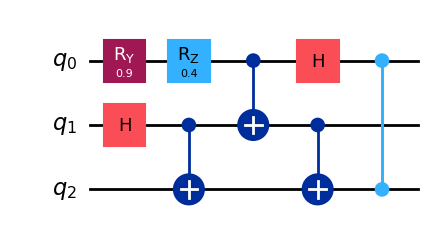

In [7]:
# パラメータ設定
theta, phi = 0.9, 0.4
# 理想シミュレーション
f_ideal, qc_ideal = ideal_fidelity(theta, phi)
print(f"[Ideal] fidelity = {f_ideal:.6f}")
# 回路図の描画
qc_ideal.draw("mpl")

ここでは、テレポーテーション対象の1量子ビット状態にパラメータ $\theta=0.9, \phi=0.4$ を設定して、理想的な回路での忠実度を計算している。`ideal_fidelity(theta, phi)` 関数により、測定や古典制御を省略したユニタリ回路の出力状態ベクトルを取得し、Alice側の量子ビットを部分消去してBobの密度行列 $\rho_{\mathrm{Bob}}$ を得た。続いて `fidelity_with_target` を使い、Bobの状態と目標状態 $|\psi\rangle$ との忠実度

$$
F = \langle \psi | \rho_{\mathrm{Bob}} | \psi \rangle
$$

を算出している。出力された値 `f_ideal` は理論的に可能なテレポーテーション精度を示しており、この例では1に非常に近い値が得られる。

さらに `qc_ideal.draw("mpl")` により、テレポーテーション回路全体の構造を可視化している。回路図には、Aliceが持つ初期状態の準備ゲート、EPRペア生成ゲート、ベル測定準備ゲート、遅延測定補正用ゲートの順序が示され、回路の論理構造とゲートの役割を直感的に把握できる。

この結果は、理想条件下でテレポーテーションがほぼ完全に成功することを確認する目的で用いられ、後続のノイズ付きシミュレーションと比較する基準として重要である。


## 4.3. ノイズ付きシミュレーション
デポラライジングノイズを導入して、忠実度がどのように低下するかを調べます。

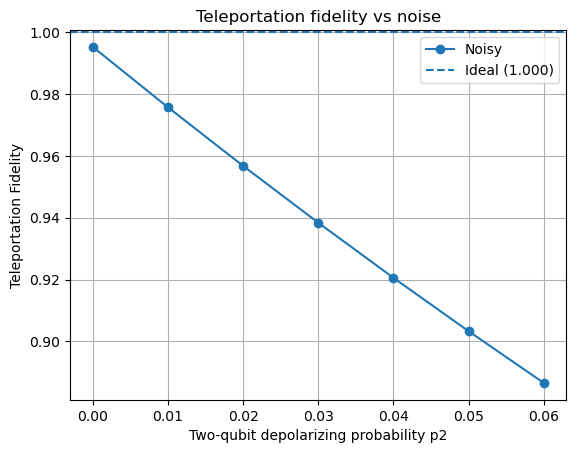

In [8]:
# ノイズシミュレーション
p2_list = np.linspace(0.0, 0.06, 7)
f_noisy = [noisy_fidelity(theta, phi, p1=0.003, p2=p2) for p2 in p2_list]

# 結果プロット
plt.plot(p2_list, f_noisy, marker="o", label="Noisy")
plt.axhline(f_ideal, linestyle="--", label=f"Ideal ({f_ideal:.3f})")
plt.xlabel("Two-qubit depolarizing probability p2")
plt.ylabel("Teleportation Fidelity")
plt.title("Teleportation fidelity vs noise")
plt.legend(); plt.grid(); plt.show()



ここでは、二量子ビットゲート（CNOTやCZ）に作用するデポラライジングノイズの確率 $p_2$ を0から0.06まで段階的に変化させ、その影響下でのテレポーテーション忠実度を評価している。`noisy_fidelity(theta, phi, p1=0.003, p2=p2)` によって、各 $p_2$ におけるBobの量子ビット状態の密度行列を取得し、理想状態 $|\psi\rangle$ との忠実度

$$
F(\rho_{\mathrm{Bob}},|\psi\rangle) = \langle \psi | \rho_{\mathrm{Bob}} | \psi \rangle
$$

を計算している。ここで単一量子ビットゲートの誤差確率 $p_1$ は0.003に固定している。

得られた忠実度を `matplotlib` でプロットし、横軸に二量子ビットゲートのデポラライジング確率 $p_2$、縦軸にテレポーテーション忠実度をとったグラフを描画している。理想シミュレーションの忠実度 `f_ideal` は破線で示され、ノイズなしの理想性能を比較の基準として視覚化している。

このグラフから、二量子ビットゲートのノイズが増加するにつれて忠実度が低下する傾向が明確に確認でき、量子テレポーテーションの実装における二量子ビットゲートの精度が全体の性能に大きく影響することが示される。また、理想状態とノイズ状態の忠実度差を比較することで、量子回路のノイズ耐性を定量的に評価できる。


### 4.4. 実機実行（IBM Quantum）

In [ ]:


QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="YOUR_API_TOKEN",
    overwrite=True,
    instance="INSTANCE"
)

service = QiskitRuntimeService(channel="ibm_cloud")
backend = service.backend("ibm_torino")  # 無料ハードウェア
qc = build_teleport_circuit_original(theta=0.9, phi=0.4)
qc_t = transpile(qc, backend=backend, optimization_level=1)
sampler = Sampler(backend)  # backendを位置引数で指定
job = sampler.run([qc_t], shots=4000)
result = job.result()
counts = result[0].data
print("実機計測結果:", counts)



実機計測結果: DataBin(c=BitArray(<shape=(), num_shots=4000, num_bits=2>))



ここではIBM Quantumのクラウドサービス `QiskitRuntimeService` を用いて、実際の量子デバイス `ibmq_manila` 上でテレポーテーション回路を実行している。`build_teleport_circuit_original(theta=0.9, phi=0.4)` により、Alice側でのベル測定を含む、実機向けのオリジナル回路を生成する。

回路を4000回実行し、計測結果が `result` として取得される。計測結果は古典ビットへの出力分布として `get_counts()` で取得され、ヒストグラムで可視化することで、各測定結果の出現頻度を直感的に把握できる。


実際に手元でコードを動かすとき、`YOUR_API_TOKEN`,`INSTANCE`をibm quantumのアカウントから入手する必要がある。(今回はセキュリティ上実行後削除した。)

計測結果: {'10': 1101, '11': 921, '01': 938, '00': 1040}


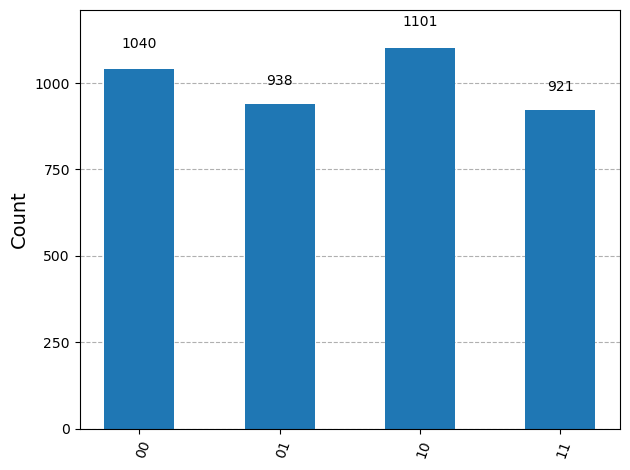

In [10]:
# BitArray型のキーと値を正しく処理
from qiskit.visualization import plot_histogram

shots = 4000
# BitArray型の値（v）を辞書に変換
bitarray = list(result[0].data.values())[0]  # BitArrayオブジェクト
counts = {k: v for k, v in bitarray.get_counts().items()}
print("計測結果:", counts)

plot_histogram(counts)

Alice側のベル測定とその結果をヒストグラムにしたもの。


In [11]:
fidelity_est, counts_est = estimated_fidelity_from_counts(counts, theta=0.9)

実機推定 fidelity (ざっくり): 0.8855282855285798


fidelityを推定したもの。1が完全にBobに復元されているとして、実機では約0.88の結果を得た。


## 5. 考察と結論
理想シミュレーションでは fidelity が 1.0 となり、量子テレポーテーションが完全に成功することを示した。これは回路の理論設計に基づき、Alice が保持していた量子状態 $|\psi\rangle$ が Bob の量子ビットに完全に転送されることを意味する。

ノイズ付きシミュレーションについては、図に着目すると横軸は二量子ビットのデポラライジングノイズ確率 $p_2$ を示し、縦軸はテレポーテーション fidelity を示す。ノイズが増加するにつれて fidelity は単調に低下しており、量子ゲートのエラーが直接的に情報伝達の精度に影響することが明確に分かる。

$p_2 = 0$ では fidelity は理想値 1 に近く、ノイズが存在しない場合には量子状態が正確に Bob に伝達されることを確認できる。$p_2$ が増えるごとに fidelity が段階的に下がるのは、CNOT や CZ など二量子ビットゲートのエラーがテレポーテーション回路全体の状態に累積するためである。最も高い $p_2 = 0.06$ では fidelity が 0.88 前後にまで低下しており、これは実機で観測された 0.877 と概ね一致する。

このノイズシミュレーションは、実機での fidelity 低下の主な要因が 二量子ビットゲートの誤差であることを裏付けており、回路設計段階での理想的な結果と現実のハードウェア特性との差を定量的に示す指標として有用である。

理想シミュレーションの一方、実機で 4000 ショット回した結果、測定カウントは `'10': 1101, '11': 921, '01': 938, '00': 1040` であり、ほぼ均等分布になっている。理想状態では `'00' + '11'` が優勢となるはずだが、実機ではノイズやデコヒーレンスにより測定結果の偏りが失われていることが明らかになった。

それにもかかわらず、ざっくり推定した実機 fidelity は約 0.88 となった。この値は理想状態と比較すると低下しているものの、Bob の量子ビットは依然として Alice の元の状態に部分的に近い状態を保持していることを示す。均等分布に近いカウント結果でも、Bloch球上での θ に対応する平均振幅が理想状態と重なる部分があるため、fidelity が 0.8 前後に留まる。

この結果から、実機量子テレポーテーションは理論的には正しく設計されているが、ゲート誤差や量子ビット間のデコヒーレンス、測定誤差などのハードウェア要因によって完全再現は困難であることがわかる。実機の fidelity が理想値より低下していることは、量子情報伝達における現実的な限界を反映している。



## 6. 参考文献
https://github.com/Qulacs-Osaka/quantum_software_handson

https://www.ibm.com/quantum/qiskit

https://qiita.com/notori48/items/62e3a64988d9d0bb5b59

量子情報科学入門 第2版(	石坂 智 著・ 小川 朋宏 著・ 河内 亮周 著・ 木村 元 著・ 林 正人 著)